# MeshGraphNets for emulating glacier velocity
## D. Brinkerhoff and J. Downs

This notebook describes the application of [MeshGraphNets](https://arxiv.org/pdf/2010.03409) by Pfaff et al. to the problem of emulating glacier velocities.  

## Training data
Ice sheets and glaciers satisfy the Navier-Stokes equations subject to some simplifications - that the Reynolds number is low so that the inertial term can be neglected (leading to the Stokes' equations), and that the fluid pressure is hydrostatic (i.e. the pressure in a parcel is given only by the weight of the overlying fluid, leading to the Blatter-Pattyn approximation),
$$\partial_x \left[ 2 \eta (2 \partial_x u + \partial_y v)\right] + \partial_y \left[\eta (\partial_y u + \partial_x v)\right] + \partial_z \left[\eta (\partial_z u) \right] = \rho g \partial_x S $$
$$\partial_x \left[\eta (\partial_y u + \partial_x v)\right] + \partial_y \left[ 2 \eta (\partial_x u + 2 \partial_y v)\right] + \partial_z \left[\eta (\partial_z v) \right] = \rho g \partial_y S, $$
plus boundary conditions that govern stresses at the ice surface and base.  The specific form of this equation is not especially important here - the important thing is that we can view this model as a function that takes ice geometry and consitutive properties of the glacier and uses those arguments to compute a vector-valued and spatially distributed velocity
$$\mathbf{u}(\mathbf{x}) = \mathcal{F}(H(\mathbf{x}),B(\mathbf{x}),\beta(\mathbf{x})).$$

The classic approach to solving this problem is to use the finite element method to solve these equations.  This works very well, but can be expensive.  In order to accelerate the process, we seek to use a MeshGraphNet model to emulate the solution operator (the functional $F$).  As a first step, we need to provide training data.  Here we use the SpecEIS ice sheet model to "grow" glaciers over several mountain ranges in western North America for randomized snowfall, melt, and basal conditions $\beta(\mathbf{x})$.  The result of this procedure is a large number of realizations of glacier geometry that are consistent with the desired physics.  From these solutions, we can easily extract desired input features (the ice thickness, the bed elevation, and the basal conditions) and the associated output features (the velocity vector).  

We can begin by pulling in some of this data from our simulations.  These live on a finite element mesh (which is a bit complicated since some of the variables live on cell centroids, some live on edges, and some live on vertices.  More on that momentarily.  




In [17]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("once",category=DeprecationWarning)
    import firedrake as df
import logging
logging.captureWarnings(True)

name = 'bitterroot_1000'
base_dir = f'../emulator_paper/training_runs/training_runs/output/{name}/'
h5_input = f'{base_dir}output_{name}.h5'
idx = 100
with df.CheckpointFile(h5_input, 'r') as afile:

    mesh = afile.load_mesh()
    B = afile.load_function(mesh, 'B')
    H = afile.load_function(mesh, 'H0', idx=idx)
    beta2 = afile.load_function(mesh, 'beta2', idx=idx)
    Ubar = afile.load_function(mesh, 'Ubar0', idx=idx)
    Udef = afile.load_function(mesh, 'Udef0', idx=idx)    

An essential element in a graph neural network like MeshGraphNet is, well, the graph.  Pytorch has a pretty nice library that can help abstract some of the important operations in GNN, which is called torch-geometric.  The most important object here is the adjacency matrix, which for pytorch geometric is just a 2D tensor that holds the indices of edges.  Here, we will primarily be working on the "dual" graph, which connects cell centers (we do this because geometry is defined on these cell centers).  This is relevant for FEM folks, but not that relevant for the ML - a graph is a graph after all.  Here is a method that converts from the firedrake mesh format into something torch-geometric can use.  

In [22]:
import torch
import torch_geometric
import torch_scatter
import numpy as np

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

class Mapper:
    def __init__(self, mesh,device=device):
        self.mesh = mesh
        V_cg = self.V_cg = df.FunctionSpace(mesh, 'CG', 1)
        V_cr = self.V_cr = df.FunctionSpace(mesh, 'CR', 1)
        V_dgt = self.V_dgt = df.VectorFunctionSpace(mesh,"DGT",0)

        # Node coordinates
        self.xs = mesh.coordinates.dat.data[:,0]
        self.ys = mesh.coordinates.dat.data[:,1]
        self.coords = np.c_[self.xs, self.ys]

        # Faces
        self.faces = faces = V_cg.cell_node_list

        # Get edges
        e0 = faces[:,[0,1]]
        e1 = faces[:,[1,2]]
        e2 = faces[:,[2,0]]
        e0.sort(axis=1)
        e1.sort(axis=1)
        e2.sort(axis=1)
        edges = np.concatenate((e0, e1, e2)) 
        edges = np.unique(edges, axis=0)

        # Edge midpoint coordinates
        x = df.SpatialCoordinate(mesh)
        x_cr = df.interpolate(x[0], V_cr).dat.data[:]
        y_cr = df.interpolate(x[1], V_cr).dat.data[:]

        ex0 = 0.5*self.xs[edges].sum(axis=1)
        ey0 = 0.5*self.ys[edges].sum(axis=1)
        ei0 = np.lexsort((ex0, ey0)) 
        ei1 = np.lexsort((x_cr, y_cr))

        edges1 = np.zeros_like(edges)
        edges1[ei1] = edges[ei0]
        edges = edges1

        edges = np.vstack((edges,edges[:,::-1]))
        self.edges = torch.tensor(edges.T,device=device)
 
        de = mesh.interior_facets.facet_cell

        self.half_edges = torch.tensor(de).T.to(torch.int64).to(device)
        
        de = np.vstack((de,de[:,::-1]))
        self.dual_edges = dual_edges = torch.tensor(de).T.to(torch.int64).to(device)
        
        cell_to_node = []
        node_to_cell = []
        for i,c in enumerate(V_cg.cell_node_list):
            for cc in c:
                #edges.append([i+V_cg.dim(),cc])
                node_to_cell.append([cc,i+V_cg.dim()])
                cell_to_node.append([i+V_cg.dim(),cc])
        self.cell_to_node = torch.tensor(cell_to_node,device=device).T
        self.node_to_cell = torch.tensor(node_to_cell,device=device).T

        phi = df.TestFunction(V_dgt)
        uu = df.TrialFunction(V_dgt)
        n = df.FacetNormal(mesh)

        A = df.dot(phi('+'),uu('+'))*df.dS + df.dot(phi,uu)*df.ds
        b = df.dot(phi('+'),n('+'))*df.dS + df.dot(phi,n)*df.ds  
        nhat = df.Function(V_dgt)

        df.solve(A==b,nhat)

        self.normal = normal = torch.tensor(nhat.dat.data[:]).to(torch.float).to(device)     

m = Mapper(mesh)


In [23]:
m.dual_edges

tensor([[    6,     4,     6,  ..., 68683, 68684, 68685],
        [    0,     0,     1,  ..., 68685, 68686, 68686]], device='cuda:0')

We will visualize the graph momentarily.  For now, we would like to use this information to build some features.  MeshGraphNets allow both node and edge features.  This is, in principle, quite straightforward - we want as cell inputs the ice thickness, bed elevation, and basal traction; and we want as edge inputs the offsets.  In practice, it's a bit more complicated.  First, the equations don't actually depend on the bed or surface elevations, but rather on their gradients.  This is important because it means that the equations are equivariant to translational shifts in elevation.  We would like the emulator to be as well, so we choose to encode the gradients (actually just the differences between cell values, since the distances are already encoded) as edge features.  

In [24]:
# Use firedrake utilities to get the cell center locations
V_dg = df.FunctionSpace(mesh,"DG",0)
X_dg = df.interpolate(mesh.coordinates[0],V_dg)
Y_dg = df.interpolate(mesh.coordinates[1],V_dg)
beta_cell = df.project(beta2,V_dg)

# Compute "jumps"
Bd_dg = B.dat.data[m.dual_edges.cpu().T]
Hd_dg = H.dat.data[m.dual_edges.cpu().T]
cx_dg = X_dg.dat.data[m.dual_edges.cpu().T]
cy_dg = Y_dg.dat.data[m.dual_edges.cpu().T]

# Edge features
Rx_dg = cx_dg[:,1] - cx_dg[:,0]
Ry_dg = cy_dg[:,1] - cy_dg[:,0]
dBdx = Bd_dg[:,1] - Bd_dg[:,0]
dHdx = Hd_dg[:,1] - Hd_dg[:,0]

x_edge = torch.tensor(np.column_stack((Rx_dg,Ry_dg,dHdx,dBdx)),device=device).to(torch.float)

# Node features
x_cell = torch.tensor(np.column_stack((H.dat.data[:],beta_cell.dat.data[:])),device=device).to(torch.float)

# Normalize cell features
x_cell_mean = x_cell.mean(axis=0)
x_cell_std = x_cell.std(axis=0)
x_cell -= x_cell_mean
x_cell /= x_cell_std

(1.333270331049337, 143.83283542589285, 8.561235221840114, 255.18968155001045)

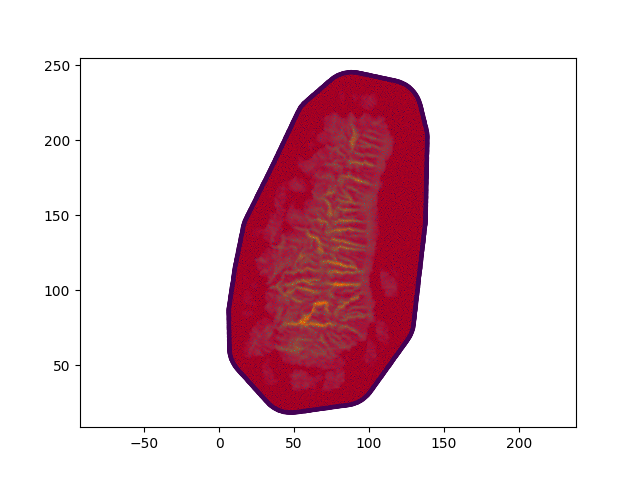

In [26]:
import matplotlib.pyplot as plt
%matplotlib widget

df.triplot(mesh)
plt.scatter(X_dg.dat.data[:],Y_dg.dat.data[:],c=H.dat.data[:])
plt.quiver(cx_dg[:,0],cy_dg[:,0],Rx_dg,Ry_dg,scale_units='xy',angles='xy',minlength=0,color='red',scale=1)
plt.axis('equal')

Now that we have features, we need to specify a model.  We will start by looking at the complete architecture, then defining the components

In [6]:
class EncoderProcessorDecoder(torch.nn.Module):
    def __init__(self, message_passing_num):

        super(EncoderProcessorDecoder, self).__init__()

        # Define encoders
        self.cell_encoder = Encoder(n_features=2,n_hidden=64,n_out=64)
        self.edge_encoder = Encoder(n_features=4,n_hidden=64,n_out=64)

        # Define message passing methods
        self.processer_list_nodes = []
        self.processer_list_edges = []
        for _ in range(message_passing_num):
            self.processer_list_nodes.append(NodeBlock(custom_func=build_mlp(2*64,64,64)))
            self.processer_list_edges.append(EdgeBlock(custom_func=build_mlp(3*64,64,64)))
        self.processer_list_nodes = torch.nn.ModuleList(self.processer_list_nodes) 
        self.processer_list_edges = torch.nn.ModuleList(self.processer_list_edges) 

        # Define decoder
        self.decoder = Decoder()

    def forward(self, x_cell, x_edge):

        # Encode cell and edge features
        h_cell = self.cell_encoder(x_cell)
        h_edge = self.edge_encoder(x_edge)

        # Perform message passing
        for nb,eb in zip(self.processer_list_nodes,self.processer_list_edges):
            h_cell = h_cell + nb(h_cell,h_edge)
            h_edge = h_edge + eb(h_cell,h_edge)

        # Decode
        decoded = self.decoder(h_cell)

        return decoded

First, let's look at the encoder.  For this we will use a simple MLP that will transform our features from the low-dimensional feature space to some embedding dimension.

In [7]:
class Encoder(torch.nn.Module):
    def __init__(self,n_features=1,n_hidden=64,n_out=64,activation=torch.nn.Tanh()):

        super(Encoder,self).__init__()
        self.encoder = build_mlp(n_features,n_hidden,n_out,lay_norm=True)

    def forward(self,x):
        x = self.encoder(x)
        return x

We will use *a lot* of MLPs, so we can create a helper function.

In [8]:
def build_mlp(in_size, hidden_size, out_size, lay_norm=True):

    module = torch.nn.Sequential(
        torch.nn.Linear(in_size, hidden_size),
        torch.nn.Tanh(),
        torch.nn.Linear(hidden_size, hidden_size),
        torch.nn.Tanh(),
        #torch.nn.Linear(hidden_size, hidden_size),
        #torch.nn.Tanh(),
        torch.nn.Linear(hidden_size, out_size)
    )
    if lay_norm: return torch.nn.Sequential(module,  torch.nn.LayerNorm(normalized_shape=out_size))
    return module

The meat of the method is in the message passing step.  We need updates for both edges and nodes.  Starting with the node update:

In [9]:
class NodeBlock(torch.nn.Module):

    def __init__(self, custom_func=None):

        super(NodeBlock, self).__init__()

        self.net = custom_func

    def forward(self, x_node, x_edge):

        # Aggregate edge features
        x_node1 = torch.zeros((x_node.shape[0], x_edge.shape[1]), device=x_node.device)
        
        torch_scatter.scatter_add(x_edge, m.dual_edges.T[:,0], dim=0, out=x_node1)
        torch_scatter.scatter_add(x_edge, m.dual_edges.T[:,1], dim=0, out=x_node1)

        # Concatenate with current node values
        x_node_ = torch.cat([
            x_node,
            x_node1
        ], dim=1)
        
        # Apply an MLP (or other defined function)
        x_node_ = self.net(x_node_)
        return x_node_

Next, we define a function for updating the edge variables

In [10]:
class EdgeBlock(torch.nn.Module):
    def __init__(self, custom_func=None):
        
        super(EdgeBlock, self).__init__()
        self.net = custom_func

    def forward(self, x_node, x_edge):

        # Concatenate values from node endpoints to current edge values.
        x_edge_ = torch.cat([
            x_node[m.dual_edges.T[:,0]],
            x_node[m.dual_edges.T[:,1]],
            x_edge
        ], dim=1)

        # Apply an MLP (or custom function)
        x_edge_ = self.net(x_edge_)  

        return x_edge_

All that remains to define is the decoder, which is another simple MLP that will operate on node features and map them back to the dimensionality of the desired output space (which in this case will be 2 - one for each velocity component)

In [11]:
class Decoder(torch.nn.Module):
    def __init__(self,n_features=64,n_hidden=64,n_out=2,activation=torch.nn.Tanh()):    
        super(Decoder,self).__init__()
        self.decoder = build_mlp(n_features,n_hidden,n_out,lay_norm=False)

    def forward(self,x):
        x = self.decoder(x)
        return x

We also need an observation vector - we can just use the velocity field from the finite element simulation.  This is a bit convoluted too - this observation is for the coefficients of a special finite element space (defined on edges), whereas our emulator prediction is vector-valued on cells, so we'll need a careful treatment for characterizing misfit.  To this end, we've implemented a couple of custom pytorch functions that compute cost as the integral over the spatial domain of the squared residual.  
$$
J(\theta) = \int_\Omega \left[\mathbf{u}_{\theta}(\mathbf{x}) - \mathbf{u}_{obs}(\mathbf{x})\right]^2 \mathrm{d}\Omega
$$

In [12]:
Ubar_obs = torch.tensor(Ubar.dat.data[:]/100.,device=device).to(torch.float)

class LossIntegral:
    def __init__(self, mesh):
        self.V_mt = df.FunctionSpace(mesh, "MTW", 3)
        self.V_rt = df.VectorFunctionSpace(mesh,"DG",0)
        self.V_dg = df.FunctionSpace(mesh, 'DG', 0)
        
        self.Ubar_obs = Ubar_obs =  df.Function(self.V_mt,name='u_obs')
        self.Ubar = Ubar = df.Function(self.V_rt,name='u_pred')
        
        self.w_bar = df.TestFunction(self.V_rt)

        c0 = df.Constant(1.)

        rbar = Ubar - Ubar_obs
        self.I = c0*df.dot(rbar, rbar)*df.dx

        self.J_bar = df.derivative(self.I, self.Ubar, self.w_bar)
        self.j_bar = df.Function(self.V_rt)


class VelocityLoss(torch.autograd.Function):
    @staticmethod
    def forward(ctx, Ubar, Ubar_obs, loss_integral):
        ctx.loss_integral = loss_integral 

        ctx.Ubar = Ubar    
        ctx.Ubar_obs = Ubar_obs

        loss_integral.Ubar_obs.dat.data[:] = Ubar_obs
        loss_integral.Ubar.dat.data[:] = Ubar

        return torch.tensor(df.assemble(loss_integral.I)) 

    @staticmethod
    def backward(ctx, grad_output):
        loss_integral = ctx.loss_integral  

        Ubar_obs = ctx.Ubar_obs
        Ubar = ctx.Ubar

        loss_integral.Ubar_obs.dat.data[:] = Ubar_obs
        loss_integral.Ubar.dat.data[:] = Ubar

        df.assemble(loss_integral.J_bar, tensor=loss_integral.j_bar) 
        j_bar = torch.tensor(loss_integral.j_bar.dat.data[:]) 

        return j_bar*grad_output, None, None, None


Now we can instantiate the model, put it on cuda, and make a prediction.

In [13]:
model = EncoderProcessorDecoder(6).to(device)
#model = torch.load('trained_model.pt')
v = model(x_cell,x_edge)

This model is not trained, so will not produce a very interesting result.  We must train it, which proceeds very much like any other torch training loop.

In [14]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

# We will save the results to paraview format for visualization.  
outfile = df.File('output/U_mod.pvd')
obsfile = df.File('output/U_obs.pvd')

# instantiate custom loss function
l = LossIntegral(mesh)

for i in range(2000):
    optimizer.zero_grad()

    # make a prediction
    u_out = model(x_cell,x_edge)

    # Unfortunately, our custom loss doesn't work on GPU
    L = VelocityLoss.apply(u_out.cpu(),Ubar_obs.cpu(),l)
    L.backward()
    optimizer.step()

    if i%10==0:
        outfile.write(l.Ubar)
        obsfile.write(l.Ubar_obs)
        print(i,L.item())
    

0 10703.132626958275
10 8782.205474568014
20 8689.524401024819
30 8602.417407342273
40 8507.497258394958
50 8393.809267569677
60 8171.637575552745
70 8214.422930137805
80 8062.0564987898915
90 7816.892150866785
100 7548.403876752916
110 8862.338480690316
120 8616.32643722019
130 8333.43513662874
140 7966.271414400686
150 7901.8683981178465
160 8216.428384478419
170 7457.599405709022
180 7699.056298270041
190 8918.211383112524
200 8853.353348514225
210 8733.415082481264
220 8685.505768282512
230 8626.878914010436
240 8538.168779627016
250 8463.282632175635
260 8377.803654267496
270 7880.043912954036
280 7591.893063114959
290 7741.150682163326
300 6917.47045962807
310 6593.192568499971
320 5916.495338148558
330 5002.4512213242115
340 4459.531786271283
350 3985.5739852929746
360 4234.2765811853415
370 4055.1927596739515
380 3748.576060875906
390 3529.178339014077
400 3419.7249872452044
410 3474.099265142244
420 3299.269552945787
430 3223.7580058938065
440 3299.8058898965414
450 3562.84838

It's helpful to fine-tune with a smaller step size for this problem.  

In [15]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
for i in range(2000):
    optimizer.zero_grad()
    u_out = model(x_cell,x_edge)
    L = VelocityLoss.apply(u_out.cpu(),Ubar_obs.cpu(),l)
    L.backward()
    optimizer.step()


    if i%10==0:
        outfile.write(l.Ubar)
        obsfile.write(l.Ubar_obs)
        print(i,L.item())


0 330.1724674524345
10 465.19967022195215
20 341.57284157153777
30 313.067886347387
40 311.52304894967443
50 307.35129267529857
60 304.6758380162343
70 303.2292602096604
80 301.7731414630717
90 300.49763394555254
100 299.3624836306392
110 298.28884324674465
120 297.2394986796262
130 296.21255505585214
140 295.1993920395109
150 294.1866602877608
160 293.18051747049896
170 292.182290078035
180 291.1708044357681
190 290.15677734334935
200 289.13552081477076
210 288.09770881406257
220 287.03862854305703
230 285.98382859978705
240 284.9287141071197
250 283.87387745296394
260 282.81733229018585
270 281.7565661164957
280 280.68273818350497
290 279.59059715863833
300 278.49193733596326
310 277.3857283662165
320 276.2896121742142
330 275.3609534678606
340 274.20670615256074
350 274.75749693834535
360 272.49602164270027
370 271.6164351417978
380 269.85157592275465
390 269.09222431923087
400 275.7269884061464
410 269.47745001107796
420 266.30868410557486
430 265.72719085278277
440 264.45447064966

We can save a trained model for later use.

In [16]:
torch.save(model,'trained_model.pt')